In [35]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import re

In [36]:
fake_news_df = pd.read_csv('fake.csv', nrows=750)
fake_news_df['status'] = 'palsu'

real_news_df = pd.read_csv('true.csv', nrows=650)
real_news_df['status'] = 'asli'

df = pd.concat([fake_news_df, real_news_df], ignore_index=True)
df = shuffle(df, random_state=22).reset_index(drop=True)

In [37]:
df.tail()

,title,text,subject,date,status
1395,CNN’s Don Lemon: Trump Shouldn’t Get Apology ...,If Donald Trump really wants an apology from E...,News,"September 18, 2017",palsu
1396,Republican Moore embraces Trump message on eve...,"BIRMINGHAM, Ala. (Reuters) - Dogged by accusat...",politicsNews,"December 11, 2017",asli
1397,Democrats plan to use tax bill to attack Repub...,WASHINGTON (Reuters) - The tax bill is Preside...,politicsNews,"December 20, 2017",asli
1398,Someone Tried To Cash In On Antifa With These...,History has shown that one of the most cost-ef...,News,"November 6, 2017",palsu
1399,Exclusive: Senator Cruz wants to cap renewable...,NEW YORK (Reuters) - U.S. Senator Ted Cruz wan...,politicsNews,"December 15, 2017",asli


In [38]:
df = df.drop(columns=['title', 'subject', 'date'])
df.dropna(inplace=True)

In [39]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)
df['text'] = df['text'].apply(lambda x: remove_punctuation(x.lower()))
df.head()

,text,status
0,washington reuters the top republican in the ...,asli
1,donald trump s current deputy national securit...,palsu
2,washington reuters us democratic senator al f...,asli
3,donald trump s administration finds new ways t...,palsu
4,washington reuters the us senate will vote on...,asli


In [40]:
status = pd.get_dummies(df['status']).astype('int64')
new_df = pd.concat([df, status], axis=1)
new_df = new_df.drop(columns='status')
new_df

,text,asli,palsu
0,washington reuters the top republican in the ...,1,0
1,donald trump s current deputy national securit...,0,1
2,washington reuters us democratic senator al f...,1,0
3,donald trump s administration finds new ways t...,0,1
4,washington reuters the us senate will vote on...,1,0
...,...,...,...
1395,if donald trump really wants an apology from e...,0,1
1396,birmingham ala reuters dogged by accusations ...,1,0
1397,washington reuters the tax bill is president ...,1,0
1398,history has shown that one of the most costeff...,0,1


In [41]:
text_news = new_df['text'].astype('str')
status_news = new_df[['asli', 'palsu']].values

In [42]:
text_train, text_test, status_train, status_test = train_test_split(text_news, status_news, test_size=0.2)

In [43]:
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          80000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                20736     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 109314 (427.01 KB)
Trainable params: 109

In [46]:
class modelCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.98):
      print("Expected accuracy have been achieved")
      self.model.stop_training = True
cb = modelCallbacks()

In [47]:
model_history = model.fit(
    padded_train,
    status_train,
    epochs=10,
    validation_data=(padded_test, status_test),
    verbose=1,
    batch_size=128,
    callbacks=[cb]
  )

Epoch 1/10
9/9 [==============================] - 5s 348ms/step - loss: 0.6901 - accuracy: 0.5589 - val_loss: 0.6814 - val_accuracy: 0.5714
Epoch 2/10
9/9 [==============================] - 6s 735ms/step - loss: 0.6740 - accuracy: 0.6652 - val_loss: 0.6464 - val_accuracy: 0.9750
Epoch 3/10
9/9 [==============================] - 3s 305ms/step - loss: 0.5737 - accuracy: 0.9420 - val_loss: 0.3724 - val_accuracy: 0.9107
Epoch 4/10
9/9 [==============================] - 6s 659ms/step - loss: 0.2724 - accuracy: 0.9170 - val_loss: 0.2064 - val_accuracy: 0.9036
Epoch 5/10
9/9 [==============================] - 4s 441ms/step - loss: 0.1210 - accuracy: 0.9759 - val_loss: 0.0862 - val_accuracy: 0.9929


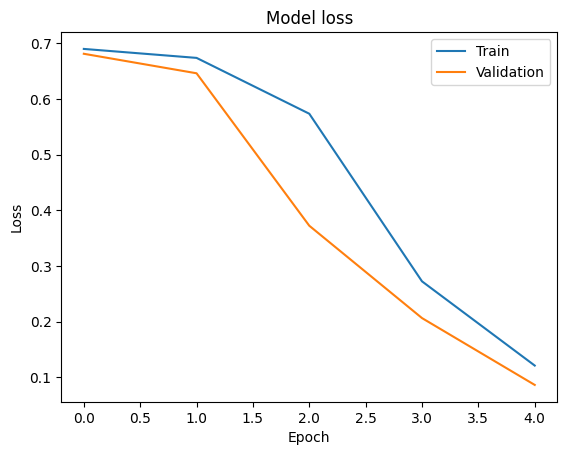

In [48]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

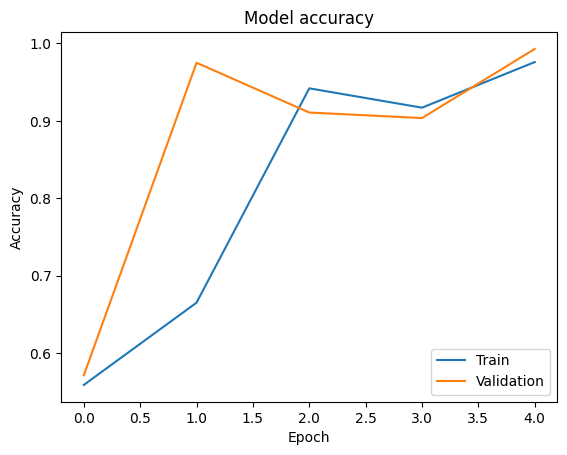

In [49]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [50]:
# Menguji Akurasi
sekuens_test = tokenizer.texts_to_sequences(text_test)
padded_test = pad_sequences(sekuens_test)
predictions = model.predict(padded_test)

predicted_labels = [1 if pred[1] > pred[0] else 0 for pred in predictions]
evaluation = model.evaluate(padded_test, status_test, verbose=0)
print(f"\nTest Accuracy: {evaluation[1]*100:.2f}%")

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(status_test.argmax(axis=1), predicted_labels))
print("\nConfusion Matrix:")
print(confusion_matrix(status_test.argmax(axis=1), predicted_labels))


9/9 [==============================] - 1s 38ms/step

Test Accuracy: 99.29%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       120
           1       0.99      0.99      0.99       160

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280


Confusion Matrix:
[[119   1]
 [  1 159]]


In [51]:
# UJI DATA PALSU
kalimat_uji = ["House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexander Downer that Russian officials were shopping around possible dirt on then-Democratic presidential nominee Hillary Clinton. Exactly how much Mr. Papadopoulos said that night at the Kensington Wine Rooms with the Australian, Alexander Downer, is unclear,  the report states.  But two months later, when leaked Democratic emails began appearing online, Australian officials passed the information about Mr. Papadopoulos to their American counterparts, according to four current and former American and foreign officials with direct knowledge of the Australians  role. Papadopoulos pleaded guilty to lying to the F.B.I. and is now a cooperating witness with Special Counsel Robert Mueller s team.This isn t a presidency. It s a badly scripted reality TV show.Photo by Win McNamee/Getty Images."]

sekuens_uji = tokenizer.texts_to_sequences(kalimat_uji)
padded_uji = pad_sequences(sekuens_uji)

prediksi_uji = model.predict(padded_uji)

label_uji = 1 if prediksi_uji[0, 1] > prediksi_uji[0, 0] else 0

# Menampilkan hasil prediksi
if label_uji == 1:
    print("Kalimat tersebut diprediksi sebagai PALSU.")
else:
    print("Kalimat tersebut diprediksi sebagai ASLI.")

1/1 [==============================] - 0s 320ms/step
Kalimat tersebut diprediksi sebagai PALSU.


In [52]:
# UJI DATA ASLI
kalimat_uji = ["White House, Congress prepare for talks on spending, immigration."]

sekuens_uji = tokenizer.texts_to_sequences(kalimat_uji)
padded_uji = pad_sequences(sekuens_uji)
prediksi_uji = model.predict(padded_uji)
label_uji = 1 if prediksi_uji[0, 1] > prediksi_uji[0, 0] else 0

# Menampilkan hasil prediksi
if label_uji == 1:
    print("Kalimat tersebut diprediksi sebagai PALSU.")
else:
    print("Kalimat tersebut diprediksi sebagai ASLI.")

1/1 [==============================] - 0s 24ms/step
Kalimat tersebut diprediksi sebagai ASLI.
